# Welcome to Jupyter!

This repo contains an introduction to [Jupyter](https://jupyter.org) and [IPython](https://ipython.org).

Outline of some basics:

* [Notebook Basics](../examples/Notebook/Notebook%20Basics.ipynb)
* [IPython - beyond plain python](../examples/IPython%20Kernel/Beyond%20Plain%20Python.ipynb)
* [Markdown Cells](../examples/Notebook/Working%20With%20Markdown%20Cells.ipynb)
* [Rich Display System](../examples/IPython%20Kernel/Rich%20Output.ipynb)
* [Custom Display logic](../examples/IPython%20Kernel/Custom%20Display%20Logic.ipynb)
* [Running a Secure Public Notebook Server](../examples/Notebook/Running%20the%20Notebook%20Server.ipynb#Securing-the-notebook-server)
* [How Jupyter works](../examples/Notebook/Multiple%20Languages%2C%20Frontends.ipynb) to run code in different languages.

You can also get this tutorial and run it on your laptop:

    git clone https://github.com/ipython/ipython-in-depth

Install IPython and Jupyter:

with [conda](https://www.anaconda.com/download):

    conda install ipython jupyter

with pip:

    # first, always upgrade pip!
    pip install --upgrade pip
    pip install --upgrade ipython jupyter

Start the notebook in the tutorial directory:

    cd ipython-in-depth
    jupyter notebook

In [3]:
import sys
!{sys.executable} -m pip install SPARQLWrapper
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import numpy as np
import datetime
import func_lib
import inspect

endpoint_url = "https://query.wikidata.org/sparql"
item = "item"


class FunctionWithSignature:
    """Specific for function applied to the entire relation,
        name is the name of the function (str)
        typeSignature is the required list of types in a relation,
        func is the function to be applied to the entire relation."""
    def __init__(self, name, typeSignature, func):
        self.func = func
        self.typeSignature = typeSignature
        self.name = name

#     def invoke(self, paramList):
#         typedParams = zip(self.typeSignature, paramList)
#         typeCheckResults = list(map(lambda x: x[1].checkType(x[0]), typedParams))
#         if false in typeCheckResults:
#             raise Exception("Input parameters don’t match type signature")
#         return fn.invoke(paramList)
    def invoke(self, df):
        return self.func(df)
    
    def showTypeRequest(self):
        return self.typeSignature

class Relation:
    """
    The class returned when createRelation is called.
    It contains string field with query.
    We call Relation.query when we need to do the query.
    """

    def __init__(self, entity_id: str, property_id: str, isSubject: bool, rowVerbose: bool,
                 colVerbose: bool, time_property: str, time: str, name: str, label: bool, limit=10000, subclass=False, showid=False):
        self.entity_id = entity_id
        self.query_str = ""
        self.dic = {}
        self.result_dic = {"Entity ID": []}
        self.df = pd.DataFrame()
        self.count = 0
        self.time_property = time_property
        self.time = time
        self.limit = limit
        self.subclass = subclass
        self.focus = "Entity ID"
        self.type_rec = {}
        if property_id:
            self.extend(property_id, isSubject, name, rowVerbose, colVerbose, limit, time_property, time, label, subclass, showid)

    def generate_html(self, name: str):
        html = (self.df).to_html()
        text_file = open(name, "w", encoding='utf-8')
        text_file.write(html)
        text_file.close()

    def query(self, require=None):
        if self.query_str == "":
            self.result_dic = {"Entity ID": ['http://www.wikidata.org/entity/' + str(self.entity_id)]}
            return self.result_dic
        results = get_results(endpoint_url, self.query_str)
        result_dict = {"Entity ID": ['http://www.wikidata.org/entity/' + str(self.entity_id)]}
        for i in range(1, self.count + 1):
            result_dict[self.dic[i]["name"] + '_' + self.dic[i]['property_id']] = []
            if self.dic[i]["colVerbose"]:
                result_dict[self.dic[i]["name"] + '_rank_' + self.dic[i]['property_id'] + '_rank'] = []
                for key, value in self.dic[i]["property_name_dic"].items():
                    result_dict[
                        self.dic[i]["name"] + "_" + value + '_' + self.dic[i]['property_id'] + '_' + str(key)] = []
                for key, value in self.dic[i]["ref_dic"].items():
                    result_dict[self.dic[i]["name"] + "_ref_" + self.dic[i]['property_id'] + '_' + str(key)] = []

            if self.dic[i]["label"]:
                result_dict[self.dic[i]["name"] + '_' + self.dic[i]['property_id'] + 'Label'] = []

        for result in results['results']['bindings']:
            for key, value in result_dict.items():
                if key in result.keys():
                    result_dict[key].append(result[key]['value'])
                else:
                    result_dict[key].append('NA')
        result_dict["Entity ID"] = ['http://www.wikidata.org/entity/' + str(self.entity_id)] * len(
            result_dict[self.dic[self.count]["name"] + '_' + self.dic[self.count]["property_id"]])
        result_dict["Basic ID"] = [str(self.entity_id)] * len(
            result_dict[self.dic[self.count]["name"] + '_' + self.dic[self.count]["property_id"]])
        self.result_dic = result_dict
        self.df = pd.DataFrame.from_dict(self.result_dic)
        for i in range(1, self.count + 1):
            if self.dic[i]["colVerbose"] and not self.dic[i]["rowVerbose"]:
                col = self.dic[i]['name'] + '_rank_' + self.dic[i]['property_id'] + '_rank'
                if any(self.df[col] == 'http://wikiba.se/ontology#PreferredRank'):
                    self.df = self.df.loc[self.df[col] == 'http://wikiba.se/ontology#PreferredRank']
                else:
                    self.df = self.df.loc[self.df[col] == 'http://wikiba.se/ontology#NormalRank']
        for i in range(1, self.count + 1):
            if self.dic[i]["showid"]:
                self.df[self.dic[i]["name"] + '_' + self.dic[i]['property_id'] + '_basic'] = self.df[self.dic[i]["name"] + '_' + self.dic[i]['property_id']].apply(lambda x: x.split('/')[-1])
#         if require is not None:
#             for r in require:
#                 self.df = self.df.loc[self.df[r] != 'NA']
        self.df = pd.DataFrame(data=self.df)
#         if self.df.shape[0] >= 10000:
#             print("Warning: Your query leads to too many results. Only 10,000 returned.")
        return self.df

    def extend(self, property_id: str, isSubject: bool, name: str, rowVerbose=False, colVerbose=False, limit=None,
               time_property=None, time=None, search=None, label=False, subclass=False, showid=False):
        self.count += 1
        self.dic[self.count] = {}
        self.dic[self.count]["name"] = name
        self.dic[self.count]["focus"] = self.focus
        self.dic[self.count]["property_id"] = property_id
        self.dic[self.count]["isSubject"] = isSubject
        self.dic[self.count]["limit"] = limit
        self.dic[self.count]["rowVerbose"] = rowVerbose
        self.dic[self.count]["colVerbose"] = colVerbose
        self.dic[self.count]['time_property'] = time_property
        self.dic[self.count]['time'] = time
        self.dic[self.count]['search'] = search
        self.dic[self.count]['label'] = label
        self.dic[self.count]['subclass'] = subclass
        self.dic[self.count]['showid'] = showid
        # subclass is specific to P31, when subclass is true, we get intance of all subclasses of the entity
        if rowVerbose or colVerbose:
            self.dic[self.count]["property_name_dic"], self.dic[self.count][
                "ref_dic"] = self.search_property_for_verbose()
        if time_property and time:
            self.time_property = time_property
            self.time = time
        if limit:
            self.limit = limit
        self.query_str = self.define_query_relation()

    def changeFocus(self, name="Entity ID"):
        self.focus = name
        
#     def extendWithFunction(self, objcolumn, func, name):
#         if type(func) == str:
#             if func.startswith('F'):
#                 try:
#                     func_id = int(func[1:])
#                     if func_id >= func_lib.func_num():
#                         raise Exception("Not available.")
#                     else:
#                         func = func_lib.func_list[func_id]
#                 except:
#                     raise Exception("Not a valid function id, a valid function id should be 'Fn', n is an integer.")
#             else:
#                 raise Exception("Not a valid function id, a valid function id should be 'Fn', n is an integer.")
#         else:
#             sig = inspect.signature(func)
#             params = sig.parameters
#             num_params = len(params)
#             num_required = 0
#             for key, value in params.items():
#                 if value.default is inspect._empty and key != 'self':
#                     num_required += 1
#             if isinstance(objcolumn, list):
#                 if len(objcolumn) > num_params:
#                     if num_params == 1 or num_params == 0:
#                         raise Exception("Too many arguments, the function only takes " + str(num_params) + " argument.")
#                     else:
#                         raise Exception("Too many arguments, the function only takes " + str(num_params) + " arguments.")
#                 if len(objcolumn) < num_required:
#                     raise Exception("Too little arguments, the function requires at least " + str(num_required) + " arguments.")
#                 count = 0
#                 for key, value in params.items():
#                     if value.default is inspect._empty and key != 'self':
#                         if (not value.annotation is inspect._empty) and (not isinstance(self.df[objcolumn[count]][0], value.annotation)):
#                             raise Exception("Please make sure the inputs meet the requirements of the arguments.")
#                         count+=1
#                 self.df[name] = self.df[objcolumn].apply(lambda x: func(*x), axis=1)
#             else:
#                 if num_required > 1:
#                     raise Exception("Too little arguments, the function requires at least " + str(num_required) + " arguments.")
#                 if num_params < 1:
#                     raise Exception("The function doesn't take any argument.")
#                 type_required = None
#                 for key, value in params.items():
#                     if value.default is inspect._empty and key != 'self':
#                         type_required = value.annotation
#                 if isinstance(self.df[objcolumn][0], type_required) or type_required is inspect._empty:
#                     self.df[name] = self.df[objcolumn].apply(func)
#                 else:
#                     raise Exception("Please make sure the input meets the requirement of the argument.")
    def extendWithFunction(self, objcolumn, func, name):
        if type(func) == str:
            if func.startswith('F'):
                try:
                    func_id = int(func[1:])
                    if func_id >= func_lib.func_num():
                        raise Exception("Not available.")
                    else:
                        func = func_lib.func_list[func_id]
                except:
                    raise Exception("Not a valid function id, a valid function id should be 'Fn', n is an integer.")
            else:
                raise Exception("Not a valid function id, a valid function id should be 'Fn', n is an integer.")
        else:
            sig = inspect.signature(func)
            params = sig.parameters
            num_params = len(params)
            num_required = 0
            for key, value in params.items():
                if value.default is inspect._empty and key != 'self':
                    num_required += 1
            if isinstance(objcolumn, list):
                if len(objcolumn) > num_params:
                    if num_params == 1 or num_params == 0:
                        raise Exception("Too many arguments, the function only takes " + str(num_params) + " argument.")
                    else:
                        raise Exception("Too many arguments, the function only takes " + str(num_params) + " arguments.")
                if len(objcolumn) < num_required:
                    raise Exception("Too little arguments, the function requires at least " + str(num_required) + " arguments.")
                count = 0
                for key, value in params.items():
                    if value.default is inspect._empty and key != 'self':
                        if (not value.annotation is inspect._empty) and ((isinstance(value.annotation, WikiDataProperty) and not objcolumn[count].split('_')[-1] in value.annotation.type_list) or
                        (not isinstance(value.annotation, WikiDataProperty) and (not isinstance(self.df[objcolumn[count]][0], value.annotation)))):
                            raise Exception("Please make sure the inputs meet the requirements of the arguments.")
                        count+=1
                self.df[name] = self.df[objcolumn].apply(lambda x: func(*x), axis=1)
            else:
                if num_required > 1:
                    raise Exception("Too little arguments, the function requires at least " + str(num_required) + " arguments.")
                if num_params < 1:
                    raise Exception("The function doesn't take any argument.")
                type_required = None
                for key, value in params.items():
                    if value.default is inspect._empty and key != 'self':
                        type_required = value.annotation
                if isinstance(self.df[objcolumn][0], type_required) or type_required is inspect._empty:
                    self.df[name] = self.df[objcolumn].apply(func)
                elif isinstance(type_required, WikiDataProperty) and objcolumn.split('_')[-1] in type_required.type_list:
                    self.df[name] = self.df[objcolumn].apply(func)
                else:
                    raise Exception("Please make sure the input meets the requirement of the argument.")

    def applyFunction(self, objcolumn, func):
        # func: FunctionWithSignature
        num_params = len(func.typeSignature)
        if len(objcolumn) != num_params:
            if num_params == 1 or num_params == 0:
                raise Exception("The function only takes Dataframe with " + str(num_params) + " column.")
            else:
                raise Exception("The function only takes Dataframe with " + str(num_params) + " columns.")
        count = 0
        # type check
        for value in func.typeSignature:
            if (isinstance(value, WikiDataProperty) and not objcolumn[count].split('_')[-1] in value.type_list) or (not isinstance(value, WikiDataProperty) and (not isinstance(self.df[objcolumn[count]][0], value))):
                raise Exception("Please make sure the input Dataframe meets the requirements of the arguments.")
            count+=1
        #        
        func.invoke(self.df[objcolumn])
        
    def define_query_relation(self):
        rdf_triple, time_filter, limit_statement = """""", """""", """"""
        if self.count < 1:
            return None
        focusChanges = 0
        for i in range(1, self.count + 1):
            if self.dic[i]["rowVerbose"] or self.dic[i]["colVerbose"]:
                if self.dic[i]["search"] is None and not self.dic[i]["isSubject"]:
                        rdf_triple += """OPTIONAL {"""
                if self.dic[i]["focus"] == "Entity ID":
#                     if self.dic[i]["search"] is None:
#                         rdf_triple += """OPTIONAL {"""
                    rdf_triple += """wd:""" + self.entity_id + """ p:""" + self.dic[i][
                        'property_id'] + """ ?statement_""" + str(i) + """. """ \
                                  + """?statement_""" + str(i) + """ ps:""" + self.dic[i][
                                      'property_id'] + """ ?""" + \
                                  self.dic[i]['name'] \
                                  + """_""" + self.dic[i]['property_id'] + """. """
                else:
                    rdf_triple += """?""" + self.dic[i]["focus"] + """ p:""" + self.dic[i][
                        'property_id'] + """ ?statement_""" + str(i) + """. """ \
                                  + """?statement_""" + str(i) + """ ps:""" + self.dic[i][
                                      'property_id'] + """ ?""" + \
                                  self.dic[i]['name'] \
                                  + """_""" + self.dic[i]['property_id'] + """. """
                for key, value in self.dic[i]["property_name_dic"].items():
                    rdf_triple += """OPTIONAL { """ + """?statement_""" + str(i) + """ pq:""" + str(key) \
                                  + """ ?""" + self.dic[i]['name'] + """_""" + value + """_""" + self.dic[i][
                                      'property_id'] + """_""" + str(key) + """.} """
                for key, value in self.dic[i]["ref_dic"].items():
                    rdf_triple += """OPTIONAL { ?statement_""" + str(
                        i) + """ prov:wasDerivedFrom ?refnode_""" + str(
                        i) + """. ?refnode_""" + str(i) \
                                  + """ pr:""" + str(key) + """ ?""" + self.dic[i]['name'] + """_ref_""" + \
                                  self.dic[i][
                                      'property_id'] + """_""" + str(key) + """.} """
                rdf_triple += """OPTIONAL { ?statement_""" + str(i) + """ wikibase:rank ?""" + self.dic[i][
                    'name'] + """_rank_""" + self.dic[i]['property_id'] + """_rank. } """
            # none-verbose version
            else:
                if self.dic[i]["focus"] == "Entity ID":
                    if self.dic[i]["isSubject"]:
                        if not self.dic[i]['subclass']:
                            rdf_triple += """?""" + self.dic[i]["name"] + """_""" + self.dic[i][
                                'property_id'] + """ wdt:""" + self.dic[i][
                                              "property_id"] + """ wd:""" + self.entity_id + """. """
                        else:
                            if self.dic[i]['property_id'] == "P31":
                                rdf_triple += """?""" + self.dic[i]["name"] + """_""" + self.dic[i][
                                    'property_id'] + """ wdt:""" + self.dic[i][
                                                  "property_id"] + """ ?subclasses. """
                                rdf_triple += """?subclasses wdt:P279+ wd:""" + self.entity_id + """. """
                    else:
                        if self.dic[i]["search"] is None:
                            rdf_triple += """OPTIONAL {"""
                        rdf_triple += """wd:""" + self.entity_id + """ wdt:""" + self.dic[i][
                            "property_id"] + """ ?""" + \
                                      self.dic[i]["name"] + """_""" + self.dic[i]['property_id'] + """. """
                else:
                    if self.dic[i]["isSubject"]:
                        if not self.dic[i]['subclass']:
                            rdf_triple += """?""" + self.dic[i]["name"] + """_""" + self.dic[i][
                                'property_id'] + """ wdt:""" + self.dic[i]["property_id"] + """ ?""" + self.dic[i][
                                              'focus'] + """. """
                        else:
                            if self.dic[i]['property_id'] == "P31":
                                rdf_triple += """?""" + self.dic[i]["name"] + """_""" + self.dic[i][
                                'property_id'] + """ wdt:""" + self.dic[i]["property_id"] + """ ?subclasses. """
                                rdf_triple += """?subclasses wdt:P279+ ?""" + self.dic[i]['focus'] + """. """
                    else:
                        if self.dic[i]["search"] is None:
                            rdf_triple += """OPTIONAL {"""
                        rdf_triple += """?""" + self.dic[i]['focus'] + """ wdt:""" + self.dic[i][
                            "property_id"] + """ ?""" + self.dic[i]["name"] + """_""" + self.dic[i][
                                          'property_id'] + """. """
            if not self.dic[i]["isSubject"]:
                if i < self.count and self.dic[i]["focus"] != self.dic[i + 1]["focus"] and self.dic[i]["search"] is None:
                    focusChanges += 1
                elif self.dic[i]["search"] is None:
                    rdf_triple += """} """
                
        for i in range(focusChanges):
            rdf_triple += """} """
        for i in range(1, self.count + 1):
            if self.dic[i]['search'] is not None and self.dic[i]["search"] != '!NA':
                if isinstance(self.dic[i]['search'], tuple):
                    if isinstance(self.dic[i]['search'][0], str):
                        rdf_triple += """FILTER (YEAR(?""" + self.dic[i]['name'] + """_""" + self.dic[i][
                            'property_id'] + """) >= """ + \
                                      self.dic[i]['search'][0] + """ && YEAR(?""" + self.dic[i]['name'] + \
                                      """_""" + self.dic[i]['property_id'] + """) <= """ + self.dic[i]['search'][
                                          1] + """) """
                    else:
                        rdf_triple += """FILTER (?""" + self.dic[i]['name'] + """_""" + self.dic[i]['property_id'] + \
                                      """ >= """ + str(self.dic[i]['search'][0]) + """ && ?""" + self.dic[i]['name'] + \
                                      """_""" + self.dic[i]['property_id'] + """ <= """ + str(
                            self.dic[i]['search'][1]) + """) """
                else:
                    rdf_triple += """FILTER (?""" + self.dic[i]['name'] + """_""" + self.dic[i][
                        'property_id'] + """ = """ + \
                                  """wd:""" + self.dic[i]['search'] + """) """
        if self.time_property is not None:
            time_filter = """?""" + self.dic[1]["name"] + """ p:""" + self.time_property + """ ?pubdateStatement.	
                          ?pubdateStatement ps:""" + self.time_property + """ ?date	
                          FILTER (YEAR(?date) = """ + self.time + """)"""
        if self.limit is not None:
            limit_statement = """LIMIT """ + str(self.limit)
        label_statement = """Service wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en" }"""
        query = """SELECT DISTINCT"""
        for i in range(1, self.count + 1):
            if self.dic[i]["rowVerbose"] or self.dic[i]["colVerbose"]:
                query += """ ?""" + self.dic[i]["name"] + """_""" + self.dic[i]['property_id']
                if self.dic[i]["label"]:
                    query += """ ?""" + self.dic[i]["name"] + """_""" + self.dic[i]['property_id'] + """Label"""
                for key, value in self.dic[i]["property_name_dic"].items():
                    query += """ ?""" + self.dic[i]["name"] + """_""" + value + """_""" + self.dic[i][
                        'property_id'] + """_""" + str(key)
                for key, value in self.dic[i]["ref_dic"].items():
                    query += """ ?""" + self.dic[i]["name"] + """_ref_""" + self.dic[i]['property_id'] + """_""" + str(
                        key)
                query += """ ?""" + self.dic[i]["name"] + """_rank_""" + self.dic[i]['property_id'] + """_rank"""
            else:
                query += """ ?""" + self.dic[i]["name"] + """_""" + self.dic[i]['property_id']
                if self.dic[i]["label"]:
                    query += """ ?""" + self.dic[i]["name"] + """_""" + self.dic[i]['property_id'] + """Label"""
        query += """ WHERE {""" + rdf_triple + time_filter + label_statement + """} """ + limit_statement
        return query

    def search_property_for_verbose(self):
        property_to_name = {}
        ref_to_name = {}
        rdf_triple, time_filter, limit_statement = """""", """""", """"""
        if self.dic[self.count]["rowVerbose"] or self.dic[self.count]["colVerbose"]:
            for i in range(1, self.count):
                if self.dic[i]["focus"] == "Entity ID":
                    if self.dic[i]["isSubject"]:
                        rdf_triple += """?""" + self.dic[i]["name"] + """ wdt:""" + self.dic[i][
                            "property_id"] + """ wd:""" + self.entity_id + """ ."""
                    else:
                        rdf_triple += """wd:""" + self.entity_id + """ wdt:""" + self.dic[i]["property_id"] + """ ?""" + \
                                      self.dic[i]["name"] + """ ."""
                else:
                    last = self.dic[i]["focus"].rfind('_')
                    focus = self.dic[i]["focus"][:last]
                    if self.dic[i]["isSubject"]:
                        rdf_triple += """?""" + self.dic[i]["name"] + """ wdt:""" + self.dic[i][
                            "property_id"] + """ ?""" + focus + """ ."""
                    else:
                        rdf_triple += """?""" + focus + """ wdt:""" + self.dic[i][
                            "property_id"] + """ ?""" + self.dic[i]["name"] + """ ."""
            if self.dic[self.count]["focus"] == "Entity ID":
                rdf_triple += """wd:""" + self.entity_id + """ p:""" + self.dic[self.count][
                    'property_id'] + """ ?statement.""" + \
                              """?statement """ + """ps:""" + self.dic[self.count]['property_id'] + """ ?item.""" + \
                              """?statement """ + """?pq """ + """?obj.""" + \
                              """?qual wikibase:qualifier ?pq.""" + \
                              """OPTIONAL{ ?statement prov:wasDerivedFrom ?refnode. ?refnode ?pr ?r.}"""
            else:
                last = self.dic[self.count]["focus"].rfind('_')
                focus = self.dic[self.count]["focus"][:last]
                rdf_triple += """?""" + focus + """ p:""" + self.dic[self.count][
                    'property_id'] + """ ?statement.""" + \
                              """?statement """ + """ps:""" + self.dic[self.count]['property_id'] + """ ?item.""" + \
                              """?statement """ + """?pq """ + """?obj.""" + \
                              """?qual wikibase:qualifier ?pq.""" + \
                              """OPTIONAL{ ?statement prov:wasDerivedFrom ?refnode. ?refnode ?pr ?r.}"""
        if self.time_property is not None:
            time_filter = """?""" + self.dic[1]["name"] + """ p:""" + self.time_property + """ ?pubdateStatement.	
                                  ?pubdateStatement ps:""" + self.time_property + """ ?date	
                                  FILTER (YEAR(?date) = """ + self.time + """)"""
        if self.limit is not None:
            limit_statement = """LIMIT """ + str(self.limit)
        label_statement = """Service wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en" }"""
        query = """SELECT DISTINCT """
        if self.dic[self.count]["rowVerbose"] or self.dic[self.count]["colVerbose"]:
            query += """?item""" + """ ?qual""" + """ ?qualLabel""" + """ ?obj """ + """?pr ?prLabel"""
            query += """ WHERE {""" + rdf_triple + time_filter + label_statement + """} """ + limit_statement
            query_result = get_results(endpoint_url, query)
            for result in query_result['results']['bindings']:
                if 'qual' in result:
                    property_to_name[result['qual']['value'].split('/')[-1]] = result['qualLabel']['value'].replace(' ',
                                                                                                                    '_')
                if 'pr' in result:
                    ref_to_name[result['pr']['value'].split('/')[-1]] = result['prLabel']['value'].replace(' ', '_')
        else:
            query += """?""" + self.dic[self.count]["name"] + """ """
        return property_to_name, ref_to_name

    def __str__(self):
        return str(self.df)

    def __getattr__(self, col_name):
        if col_name in self.df.columns:
            return self.df[col_name]
        else:
            print(col_name + " has not been found.")
            return None

        
class WikiDataType:
    def __init__(self, entity_id: list):
        self.entity_id = entity_id
        self.type_list = []
        for entity in self.entity_id:
            query_str = """SELECT DISTINCT ?s WHERE {?s wdt:P279+ wd:""" + entity + """. Service wikibase:label { 
                bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en" }}"""
            results = get_results(endpoint_url, query_str)
            self.type_list.append(entity)
            for result in results['results']['bindings']:
                self.type_list.append(result['s']['value'].split('/')[-1])

    def __instancecheck__(self, inst):
        inst = inst.split('/')[-1]
        type_list = []
        query_str = """SELECT DISTINCT ?s WHERE {wd:""" + inst + """ wdt:P31 ?s. Service wikibase:label { 
            bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en" }}"""
        results = get_results(endpoint_url, query_str)
        for result in results['results']['bindings']:
            type_list.append(result['s']['value'].split('/')[-1])
        for type_temp in type_list:
            if type_temp in self.type_list:
                return True
        return False

class WikiDataProperty:
    def __init__(self, property_id: list):
        self.property_id = property_id
        self.type_list = []
        for property_id in self.property_id:
            self.type_list.append(property_id.split('/')[-1])
    
def createRelation(entity_id: str, property_id=None, isSubject=None, rowVerbose=None, colVerbose=None,
                   time_property=None, time=None, name=None, label=False, limit=None, subclass=False):
    if property_id and not name:
        print("Please specify the name of the first column")
        return None
    return Relation(entity_id, property_id, isSubject, rowVerbose, colVerbose, time_property, time, name, label, limit, subclass)

def get_Firstname(name: str):
    return name.split(' ')[0]

def get_Lastname(name: str):
    return name.split(' ')[-1]

def remove_prefix(text, prefix):
    if text.startswith(prefix):
        return text[len(prefix):]
    return text


def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


def get_name(id: str):
    query = """PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 	
                PREFIX wd: <http://www.wikidata.org/entity/> 	
                select  *	
                where {	
                wd:""" + id + """ rdfs:label ?label .	
                FILTER (langMatches( lang(?label), "EN" ) )	
                } 	
                LIMIT 1"""
    results = get_results(endpoint_url, query)
    result = ''
    for res in results["results"]["bindings"]:
        result = res['label']['value']
    return result


You should consider upgrading via the '/Users/jack/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [8]:
print("20 Singers")
r = createRelation("Q177220")
r.extend("P106", True, "Singer", limit=20)
r.changeFocus("Singer_P106")
r.extend("P569", False, "Date_of_Birth")
r.query()
r.df

20 Singers


,Entity ID,Singer_P106,Date_of_Birth_P569
0,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q12012,1980-09-07T00:00:00Z
1,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q12010,1989-06-04T00:00:00Z
2,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q12007,1990-10-29T00:00:00Z
3,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q1779,1901-08-04T00:00:00Z
4,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q4826,1878-03-17T00:00:00Z
5,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q4826,1876-01-25T00:00:00Z
6,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q7241,1861-05-07T00:00:00Z
7,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q5170,1155-01-01T00:00:00Z
8,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q8876,1970-05-29T00:00:00Z
9,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q11901,1970-07-08T00:00:00Z


In [9]:
def age_cal(birth):
    if birth == 'NA':
        return 'NA'
    date_time_obj = datetime.datetime.strptime(birth[:4], '%Y')
    return datetime.datetime.now().year - date_time_obj.year

r.extendWithFunction('Date_of_Birth_P569',age_cal,'Age')

r.df

,Entity ID,Singer_P106,Date_of_Birth_P569,Age
0,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q12012,1980-09-07T00:00:00Z,40
1,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q12010,1989-06-04T00:00:00Z,31
2,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q12007,1990-10-29T00:00:00Z,30
3,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q1779,1901-08-04T00:00:00Z,119
4,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q4826,1878-03-17T00:00:00Z,142
5,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q4826,1876-01-25T00:00:00Z,144
6,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q7241,1861-05-07T00:00:00Z,159
7,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q5170,1155-01-01T00:00:00Z,865
8,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q8876,1970-05-29T00:00:00Z,50
9,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q11901,1970-07-08T00:00:00Z,50


In [10]:
print("20 Singers")
r = createRelation("Q177220")
r.extend("P106", True, "Singer", limit=20, label=True)
r.changeFocus("Singer_P106")
r.extend("P569", False, "Date_of_Birth")
r.query()
r.df

20 Singers


,Entity ID,Singer_P106,Singer_P106Label,Date_of_Birth_P569
0,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q2680,Bruce Willis,1955-03-19T00:00:00Z
1,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q8741,Rüdiger Skoczowsky,1986-01-01T00:00:00Z
2,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q3008,Mike Oldfield,1953-05-15T00:00:00Z
3,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q1698,Serge Gainsbourg,1928-04-02T00:00:00Z
4,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q10681,Alan Stivell,1944-01-06T00:00:00Z
5,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q1203,John Lennon,1940-10-09T00:00:00Z
6,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q1453,Alexandra Stan,1989-06-10T00:00:00Z
7,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q4826,Rosa Valetti,1878-03-17T00:00:00Z
8,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q1225,Bruce Springsteen,1949-09-23T00:00:00Z
9,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q10695,Dan Ar Braz,1949-01-15T00:00:00Z


In [11]:
r.extendWithFunction('Singer_P106Label','F1','First Name')
r.extendWithFunction('Singer_P106Label','F2','Last Name')

r.df

,Entity ID,Singer_P106,Singer_P106Label,Date_of_Birth_P569,First Name,Last Name
0,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q2680,Bruce Willis,1955-03-19T00:00:00Z,Bruce,Willis
1,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q8741,Rüdiger Skoczowsky,1986-01-01T00:00:00Z,Rüdiger,Skoczowsky
2,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q3008,Mike Oldfield,1953-05-15T00:00:00Z,Mike,Oldfield
3,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q1698,Serge Gainsbourg,1928-04-02T00:00:00Z,Serge,Gainsbourg
4,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q10681,Alan Stivell,1944-01-06T00:00:00Z,Alan,Stivell
5,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q1203,John Lennon,1940-10-09T00:00:00Z,John,Lennon
6,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q1453,Alexandra Stan,1989-06-10T00:00:00Z,Alexandra,Stan
7,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q4826,Rosa Valetti,1878-03-17T00:00:00Z,Rosa,Valetti
8,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q1225,Bruce Springsteen,1949-09-23T00:00:00Z,Bruce,Springsteen
9,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q10695,Dan Ar Braz,1949-01-15T00:00:00Z,Dan,Braz


In [4]:
func_lib.func_num()

4

In [5]:
def get_entity_id(url):
    return url.split('/')[-1]

func_lib.add_func(get_entity_id)

func_lib.func_num()

5

In [7]:
r.extendWithFunction('Entity ID','F4','id')

In [8]:
r.df

,Entity ID,Singer_P106,Singer_P106Label,Date_of_Birth_P569,First Name,Last Name,id
0,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q2680,Bruce Willis,1955-03-19T00:00:00Z,Bruce,Willis,Q177220
1,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q8741,Rüdiger Skoczowsky,1986-01-01T00:00:00Z,Rüdiger,Skoczowsky,Q177220
2,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q3008,Mike Oldfield,1953-05-15T00:00:00Z,Mike,Oldfield,Q177220
3,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q1698,Serge Gainsbourg,1928-04-02T00:00:00Z,Serge,Gainsbourg,Q177220
4,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q10681,Alan Stivell,1944-01-06T00:00:00Z,Alan,Stivell,Q177220
5,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q1203,John Lennon,1940-10-09T00:00:00Z,John,Lennon,Q177220
6,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q1453,Alexandra Stan,1989-06-10T00:00:00Z,Alexandra,Stan,Q177220
7,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q4826,Rosa Valetti,1878-03-17T00:00:00Z,Rosa,Valetti,Q177220
8,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q1225,Bruce Springsteen,1949-09-23T00:00:00Z,Bruce,Springsteen,Q177220
9,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q10695,Dan Ar Braz,1949-01-15T00:00:00Z,Dan,Braz,Q177220


In [11]:
r = createRelation("Q1137809")
r.extend('P31',True, 'Courthouse', limit=10, label=True)
r.changeFocus('Courthouse_P31')
r.extend('P17',False, 'Country')
r.query()
r.df

,Entity ID,Courthouse_P31,Courthouse_P31Label,Country_P17
0,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q7863296,U.S. Post Office and Courthouse,http://www.wikidata.org/entity/Q30
1,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q7863297,U.S. Post Office and Courthouse,http://www.wikidata.org/entity/Q30
2,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q7889666,United States Court House,http://www.wikidata.org/entity/Q30
3,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q7889667,United States Court House,http://www.wikidata.org/entity/Q30
4,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q7889682,United States Courthouse,http://www.wikidata.org/entity/Q30
5,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q7889683,United States Courthouse,http://www.wikidata.org/entity/Q30
6,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q7889685,United States Courthouse,http://www.wikidata.org/entity/Q30
7,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q7889703,United States Customhouse,http://www.wikidata.org/entity/Q30
8,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q7889714,United States Customhouse,http://www.wikidata.org/entity/Q30
9,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q7891082,United States Post Office and Courthouse,http://www.wikidata.org/entity/Q30


In [6]:
import requests
from bs4 import BeautifulSoup
print("20 Singers")
r = createRelation("Q177220")
r.extend("P106", True, "Singer", limit=20,label=True)
r.changeFocus("Singer_P106")
r.extend("P569", False, "Date_of_Birth")
r.extend("P570", False, "Date_of_Death")
r.query()

def age_cal(birth, death):
    if birth == 'NA':
        return 'NA'
    if death == 'NA':  
        date_time_obj = datetime.datetime.strptime(birth[:4], '%Y')
        return datetime.datetime.now().year - date_time_obj.year
    else:
        return datetime.datetime.strptime(death[:4], '%Y').year - datetime.datetime.strptime(birth[:4], '%Y').year

def textual_summary(x):
    url = 'https://en.wikipedia.org/wiki/'
    for word in x.split(' '):
        url += (word + '_')
    url = url[:-1]
    s = requests.session()
    r = s.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')
    results = soup.find(id='bodyContent')
    results = results.find(id='mw-content-text')
    results = results.find_all('p')
    if len(results) > 1:
        return results[1].text
    return results[0].text
    
r.extendWithFunction(['Date_of_Birth_P569','Date_of_Death_P570'], 'F3','Age')
r.extendWithFunction('Singer_P106Label',textual_summary,'summary')
for index, row in r.df.iterrows():
    print(row['summary'])
r.df

20 Singers
Other reasons this message may be displayed:

Artist was born in Buffalo, New York to Darrell and Judith Artist, and grew up in Williamsville, New York.[3][4] His father is African American, while his mother is of Polish descent.[5] He has a younger sister named Jenna. He took lessons through the Community Music School in Buffalo, New York.[3]

Rainhard Fendrich, called "Raini" by his friends, attended a Catholic boarding school. By his own admission he was a lazy pupil, and shy. He got his first guitar on his 15th birthday, taught himself how to play and started writing songs.[citation needed] He began to study law, but gave it up to embark on a career as actor and singer.

Netsky may refer to

James Douglas Morrison (December 8, 1943 – July 3, 1971) was an American singer, songwriter and poet, who served as the lead vocalist of the rock band The Doors. Due to his wild personality, poetic lyrics, his widely recognized voice, unpredictable and erratic performances, and the d

,Entity ID,Singer_P106,Singer_P106Label,Date_of_Birth_P569,Date_of_Death_P570,Age,summary
0,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q45570,Fredl Fesl,1947-07-07T00:00:00Z,NA,73,Other reasons this message may be displayed:\n
1,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q43950,Jacob Artist,1992-10-17T00:00:00Z,NA,28,"Artist was born in Buffalo, New York to Darrel..."
2,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q45402,Rainhard Fendrich,1955-02-27T00:00:00Z,NA,65,"Rainhard Fendrich, called ""Raini"" by his frien..."
3,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q44399,Netsky,1989-03-22T00:00:00Z,NA,31,Netsky may refer to\n
4,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q44301,Jim Morrison,1943-12-08T00:00:00Z,1971-07-03T00:00:00Z,28,"James Douglas Morrison (December 8, 1943 – Jul..."
5,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q44909,Candye Kane,1961-11-13T00:00:00Z,2016-05-06T00:00:00Z,55,"Kane was born Candice Caleb in Ventura, Califo..."
6,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q44909,Candye Kane,1961-11-13T00:00:00Z,2016-05-09T00:00:00Z,55,"Kane was born Candice Caleb in Ventura, Califo..."
7,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q43901,Jakob Geis,1840-12-27T00:00:00Z,1908-03-03T00:00:00Z,68,Originally he wanted to become a Catholic prie...
8,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q46053,Clive Dunn,1920-01-09T00:00:00Z,2012-11-06T00:00:00Z,92,Clive Robert Benjamin Dunn OBE (9 January 192...
9,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q46036,Lucrecia,1967-03-15T00:00:00Z,NA,53,Lucrezia or Lucrecia may refer to:\n


In [11]:
pip install beautifulsoup4

You should consider upgrading via the '/Users/jack/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [39]:
def textual_summary(x):
    url = 'https://en.wikipedia.org/wiki/'
    for word in x.split(' '):
        url += (word + '_')
    url = url[:-1]
    s = requests.session()
    r = s.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')
    results = soup.find(id='bodyContent')
    results = results.find(id='mw-content-text')
    results = results.find_all('p')
    return results[1].text

textual_summary('Mark Hoppus')

"Mark Allan Hoppus (born March 15, 1972)[1] is an American musician, singer, songwriter, record producer, and former television personality best known as the bassist and co-lead vocalist of the rock band Blink-182, as well as part of pop rock duo Simple Creatures with All Time Low's Alex Gaskarth.\n"

In [2]:
r = createRelation("Q177220")
r.extend("P106", True, "Singer", limit=20,label=True)
r.changeFocus("Singer_P106")
r.extend("P569", False, "Date_of_Birth")
r.extend("P570", False, "Date_of_Death")
r.query()

r.extendWithFunction(['Date_of_Birth_P569','Date_of_Death_P570'], 'F3','Age')
r.extendWithFunction('Singer_P106Label','F4','textual_summary')
for index, row in r.df.iterrows():
    print(row['textual_summary'])
r.df

Other reasons this message may be displayed:

Artist was born in Buffalo, New York to Darrell and Judith Artist, and grew up in Williamsville, New York
Rainhard Fendrich, called "Raini" by his friends, attended a Catholic boarding school
Netsky may refer to

James Douglas Morrison (December 8, 1943 – July 3, 1971) was an American singer, songwriter and poet, who served as the lead vocalist of the rock band The Doors
Kane was born Candice Caleb in Ventura, California
Kane was born Candice Caleb in Ventura, California
Originally he wanted to become a Catholic priest
 Clive Robert Benjamin Dunn OBE (9 January 1920 – 6 November 2012) was an English actor, comedian, artist, author, and singer
Lucrezia or Lucrecia  may refer to:

Sigmund Esco Jackson was born on his mother Katherine's 21st birthday in 1951
In 2008, Cale, along with Clapton, received a Grammy Award for their album The Road to Escondido
Christopher Keith Irvine (born November 9, 1970), better known by his ring name Chris Jeric

,Entity ID,Singer_P106,Singer_P106Label,Date_of_Birth_P569,Date_of_Death_P570,Age,textual_summary
0,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q45570,Fredl Fesl,1947-07-07T00:00:00Z,NA,73,Other reasons this message may be displayed:\n
1,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q43950,Jacob Artist,1992-10-17T00:00:00Z,NA,28,"Artist was born in Buffalo, New York to Darrel..."
2,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q45402,Rainhard Fendrich,1955-02-27T00:00:00Z,NA,65,"Rainhard Fendrich, called ""Raini"" by his frien..."
3,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q44399,Netsky,1989-03-22T00:00:00Z,NA,31,Netsky may refer to\n
4,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q44301,Jim Morrison,1943-12-08T00:00:00Z,1971-07-03T00:00:00Z,28,"James Douglas Morrison (December 8, 1943 – Jul..."
5,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q44909,Candye Kane,1961-11-13T00:00:00Z,2016-05-06T00:00:00Z,55,"Kane was born Candice Caleb in Ventura, Califo..."
6,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q44909,Candye Kane,1961-11-13T00:00:00Z,2016-05-09T00:00:00Z,55,"Kane was born Candice Caleb in Ventura, Califo..."
7,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q43901,Jakob Geis,1840-12-27T00:00:00Z,1908-03-03T00:00:00Z,68,Originally he wanted to become a Catholic priest
8,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q46053,Clive Dunn,1920-01-09T00:00:00Z,2012-11-06T00:00:00Z,92,Clive Robert Benjamin Dunn OBE (9 January 192...
9,http://www.wikidata.org/entity/Q177220,http://www.wikidata.org/entity/Q46036,Lucrecia,1967-03-15T00:00:00Z,NA,53,Lucrezia or Lucrecia may refer to:\n


In [4]:
r = createRelation("Q177220")
r.extend("P106", True, "Singer", limit=20,label=True)
r.changeFocus("Singer_P106")
r.extend('P18',False,'image')
r.query()
r.df
for index, row in r.df.iterrows():
    print(row['image_P18'])

http://commons.wikimedia.org/wiki/Special:FilePath/Daniel%20Balavoine.jpg
http://commons.wikimedia.org/wiki/Special:FilePath/CEELOGREENGBB.jpg
http://commons.wikimedia.org/wiki/Special:FilePath/Woody%20Guthrie.jpg
http://commons.wikimedia.org/wiki/Special:FilePath/Tupac%20graffiti%20New%20York.jpg
http://commons.wikimedia.org/wiki/Special:FilePath/Festival%20de%20Cornouaille%202016%20-%20Alan%20Stivell%20-%2001.jpg
http://commons.wikimedia.org/wiki/Special:FilePath/George%20Harrison%201974.jpg
http://commons.wikimedia.org/wiki/Special:FilePath/James%20Brown%202001.jpg
http://commons.wikimedia.org/wiki/Special:FilePath/Marilyn%20Monroe%20in%201952%20TFA.jpg
http://commons.wikimedia.org/wiki/Special:FilePath/Louis%20Armstrong%20restored.jpg
http://commons.wikimedia.org/wiki/Special:FilePath/Paul%20McCartney%20in%20October%202018.jpg
http://commons.wikimedia.org/wiki/Special:FilePath/Rabindranath%20Tagore%20in%201909.jpg
http://commons.wikimedia.org/wiki/Special:FilePath/Heino%20FFM13%200

In [2]:
import requests

def pob(x):
    if x == 'NA':
        return 'NA'
    url = 'https://www.google.com/maps/place/'
    for word in x.split(' '):
        url += (word + '%20')
    url = url[:-3]
    r = requests.get(url)
    return r.url
   
pd.set_option('display.max_colwidth', 1000)
r = createRelation("Q11696")
r.extend('P39',True, 'President', limit=20,label=True)
r.changeFocus('President_P39')
r.extend('P19',False, 'Place_of_birth',label=True)
r.query()
r.extendWithFunction('Place_of_birth_P19Label', pob, 'url')
r.df
# for index, row in r.df.iterrows():
#     print(row['url'])

,Entity ID,President_P39,President_P39Label,Place_of_birth_P19,Place_of_birth_P19Label,url
0,http://www.wikidata.org/entity/Q11696,http://www.wikidata.org/entity/Q3545001,Gonzo the Mechanical Bastard,NA,NA,NA
1,http://www.wikidata.org/entity/Q11696,http://www.wikidata.org/entity/Q11806,John Adams,http://www.wikidata.org/entity/Q16101,Braintree,https://www.google.com/sorry/index?continue=https://www.google.com/maps/place/Braintree&q=EgRC1BQIGI-Yiv0FIhkA8aeDS80fb6Pp3q87bQEHkvEJXlSyoqePMgFy
2,http://www.wikidata.org/entity/Q11696,http://www.wikidata.org/entity/Q608408,Caroline Reynolds,NA,NA,NA
3,http://www.wikidata.org/entity/Q11696,http://www.wikidata.org/entity/Q7242478,Prez,NA,NA,NA
4,http://www.wikidata.org/entity/Q11696,http://www.wikidata.org/entity/Q1052076,Sylar,NA,NA,NA
5,http://www.wikidata.org/entity/Q11696,http://www.wikidata.org/entity/Q22686,Donald Trump,http://www.wikidata.org/entity/Q23497866,Jamaica Hospital,https://www.google.com/sorry/index?continue=https://www.google.com/maps/place/Jamaica%2520Hospital&q=EgRC1BQIGJCYiv0FIhkA8aeDSxD6WnO-J0aJzMxif6qcZItn0S6dMgFy
6,http://www.wikidata.org/entity/Q11696,http://www.wikidata.org/entity/Q35498,Chester A. Arthur,http://www.wikidata.org/entity/Q1393235,Fairfield,https://www.google.com/sorry/index?continue=https://www.google.com/maps/place/Fairfield&q=EgRC1BQIGJKYiv0FIhkA8aeDSxr42sDf_k5ZHO9im-uqVl1rkBZEMgFy
7,http://www.wikidata.org/entity/Q11696,http://www.wikidata.org/entity/Q35236,Herbert Hoover,http://www.wikidata.org/entity/Q1798762,West Branch,https://www.google.com/sorry/index?continue=https://www.google.com/maps/place/West%2520Branch&q=EgRC1BQIGJSYiv0FIhkA8aeDSxkxp7sHFMrMV1hQ1Hd0g9bWkj_AMgFy
8,http://www.wikidata.org/entity/Q11696,http://www.wikidata.org/entity/Q9916,Dwight D. Eisenhower,http://www.wikidata.org/entity/Q534669,Denison,https://www.google.com/sorry/index?continue=https://www.google.com/maps/place/Denison&q=EgRC1BQIGJWYiv0FIhkA8aeDS4miOTu9kUgxNx9flzu215GcogvbMgFy
9,http://www.wikidata.org/entity/Q11696,http://www.wikidata.org/entity/Q11881,John Tyler,http://www.wikidata.org/entity/Q337348,Charles City County,https://www.google.com/sorry/index?continue=https://www.google.com/maps/place/Charles%2520City%2520County&q=EgRC1BQIGJaYiv0FIhkA8aeDS7NfJ01rPlLwqXAB9RNPGCEhdDFCMgFy


In [ ]:
pd.set_option('display.max_colwidth', 1000)
r = createRelation("Q177220")
r.extend("P106", True, "Singer", limit=20,label=True)
r.changeFocus("Singer_P106")
r.extend("P569", False, "Date_of_Birth")
r.extend("P570", False, "Date_of_Death")
r.query()
r.extendWithFunction(['Date_of_Birth_P569','Date_of_Death_P570'], 'F3','Age')
# r.extendWithFunction('Singer_P106Label','F4','textual_summary')
r.extendWithFunction('Age','F6','Age_1')
r.df

In [3]:
r = createRelation("Q11696")
r.extend('P39',True, 'President', limit=20,label=True)
r.changeFocus('President_P39')
r.extend('P19',False, 'Place_of_birth',label=True)
r.query()
r.extendWithFunction('Place_of_birth_P19Label', 'F5', 'url')
r.df

,Entity ID,President_P39,President_P39Label,Place_of_birth_P19,Place_of_birth_P19Label,url
0,http://www.wikidata.org/entity/Q11696,http://www.wikidata.org/entity/Q3545001,Gonzo the Mechanical Bastard,NA,NA,NA
1,http://www.wikidata.org/entity/Q11696,http://www.wikidata.org/entity/Q11806,John Adams,http://www.wikidata.org/entity/Q16101,Braintree,https://www.google.com/maps/place/Braintree
2,http://www.wikidata.org/entity/Q11696,http://www.wikidata.org/entity/Q608408,Caroline Reynolds,NA,NA,NA
3,http://www.wikidata.org/entity/Q11696,http://www.wikidata.org/entity/Q7242478,Prez,NA,NA,NA
4,http://www.wikidata.org/entity/Q11696,http://www.wikidata.org/entity/Q1052076,Sylar,NA,NA,NA
5,http://www.wikidata.org/entity/Q11696,http://www.wikidata.org/entity/Q22686,Donald Trump,http://www.wikidata.org/entity/Q23497866,Jamaica Hospital,https://www.google.com/maps/place/Jamaica%20Hospital
6,http://www.wikidata.org/entity/Q11696,http://www.wikidata.org/entity/Q35498,Chester A. Arthur,http://www.wikidata.org/entity/Q1393235,Fairfield,https://www.google.com/maps/place/Fairfield
7,http://www.wikidata.org/entity/Q11696,http://www.wikidata.org/entity/Q35236,Herbert Hoover,http://www.wikidata.org/entity/Q1798762,West Branch,https://www.google.com/maps/place/West%20Branch
8,http://www.wikidata.org/entity/Q11696,http://www.wikidata.org/entity/Q9916,Dwight D. Eisenhower,http://www.wikidata.org/entity/Q534669,Denison,https://www.google.com/maps/place/Denison
9,http://www.wikidata.org/entity/Q11696,http://www.wikidata.org/entity/Q11881,John Tyler,http://www.wikidata.org/entity/Q337348,Charles City County,https://www.google.com/maps/place/Charles%20City%20County


In [4]:
def add_one(x):
    return x+1

func_lib.add_func(add_one)

In [6]:
func_lib.func_num()

7

In [2]:
gov_building_class = 'Gov_Building'
qnum = 'Q16831714' # qnum of government building
r = createRelation(qnum, label=True)
r.extend('P31', True, gov_building_class, label=True) # extend via property P279 = is subclass of
r.query()
r.df

,Entity ID,Gov_Building_P31,Gov_Building_P31Label
0,http://www.wikidata.org/entity/Q16831714,http://www.wikidata.org/entity/Q167479,J. Edgar Hoover Building
1,http://www.wikidata.org/entity/Q16831714,http://www.wikidata.org/entity/Q195905,Canada House
2,http://www.wikidata.org/entity/Q16831714,http://www.wikidata.org/entity/Q481222,Q481222
3,http://www.wikidata.org/entity/Q16831714,http://www.wikidata.org/entity/Q359185,Admiralty building in Saint Petersburg
4,http://www.wikidata.org/entity/Q16831714,http://www.wikidata.org/entity/Q478926,Casa Rosada
...,...,...,...
537,http://www.wikidata.org/entity/Q16831714,http://www.wikidata.org/entity/Q99311644,Conseil d'Etat
538,http://www.wikidata.org/entity/Q16831714,http://www.wikidata.org/entity/Q86699176,"Building of Deputy Ministry of Research, Innov..."
539,http://www.wikidata.org/entity/Q16831714,http://www.wikidata.org/entity/Q85799521,Sandpoint Federal Building
540,http://www.wikidata.org/entity/Q16831714,http://www.wikidata.org/entity/Q86691009,Building of Deputy Ministry of Tourism (Cyprus)


In [3]:
gov_building_class = 'Gov_Building'
qnum = 'Q16831714' # qnum of government building
r = createRelation(qnum, label=True)
r.extend('P31', True, gov_building_class, label=True, subclass=True) # extend via property P279 = is subclass of
r.query()
r.df

,Entity ID,Gov_Building_P31,Gov_Building_P31Label
0,http://www.wikidata.org/entity/Q16831714,http://www.wikidata.org/entity/Q138101,Conciergerie
1,http://www.wikidata.org/entity/Q16831714,http://www.wikidata.org/entity/Q227684,Q227684
2,http://www.wikidata.org/entity/Q16831714,http://www.wikidata.org/entity/Q187723,Zellengefängnis Lehrter Straße
3,http://www.wikidata.org/entity/Q16831714,http://www.wikidata.org/entity/Q240549,Vladimir Central Prison
4,http://www.wikidata.org/entity/Q16831714,http://www.wikidata.org/entity/Q258932,Florida State Prison
...,...,...,...
23693,http://www.wikidata.org/entity/Q16831714,http://www.wikidata.org/entity/Q96943014,Union County Courthouse
23694,http://www.wikidata.org/entity/Q16831714,http://www.wikidata.org/entity/Q77978641,Greymouth Courthouse
23695,http://www.wikidata.org/entity/Q16831714,http://www.wikidata.org/entity/Q98961432,Q98961432
23696,http://www.wikidata.org/entity/Q16831714,http://www.wikidata.org/entity/Q90900654,Cumberland County Courthouse


In [6]:
r = createRelation('Q515', label=True) # city
r.extend('P31', True, 'city', label=True)
r.query()
print('Ann Arbor' in r.df.values)
r.df

False


,Entity ID,city_P31,city_P31Label
0,http://www.wikidata.org/entity/Q515,http://www.wikidata.org/entity/Q585,Oslo
1,http://www.wikidata.org/entity/Q515,http://www.wikidata.org/entity/Q749,Groningen
2,http://www.wikidata.org/entity/Q515,http://www.wikidata.org/entity/Q1533,Caracas
3,http://www.wikidata.org/entity/Q515,http://www.wikidata.org/entity/Q1513,Nagpur
4,http://www.wikidata.org/entity/Q515,http://www.wikidata.org/entity/Q1757,Helsinki
...,...,...,...
9525,http://www.wikidata.org/entity/Q515,http://www.wikidata.org/entity/Q97646739,Lora del Rio
9526,http://www.wikidata.org/entity/Q515,http://www.wikidata.org/entity/Q97643883,Montemolín
9527,http://www.wikidata.org/entity/Q515,http://www.wikidata.org/entity/Q97647058,Gerena
9528,http://www.wikidata.org/entity/Q515,http://www.wikidata.org/entity/Q97648125,Alcolea del Rio


In [7]:
r = createRelation('Q515', label=True) # city
r.extend('P31', True, 'city', label=True, subclass=True)
r.query()
print('Ann Arbor' in r.df.values)
r.df

True


,Entity ID,city_P31,city_P31Label
0,http://www.wikidata.org/entity/Q515,http://www.wikidata.org/entity/Q1718,Düsseldorf
1,http://www.wikidata.org/entity/Q515,http://www.wikidata.org/entity/Q1707,Kiel
2,http://www.wikidata.org/entity/Q515,http://www.wikidata.org/entity/Q1721,Wiesbaden
3,http://www.wikidata.org/entity/Q515,http://www.wikidata.org/entity/Q2100,Duisburg
4,http://www.wikidata.org/entity/Q515,http://www.wikidata.org/entity/Q2119,Mannheim
...,...,...,...
20248,http://www.wikidata.org/entity/Q515,http://www.wikidata.org/entity/Q791387,Avrig
20249,http://www.wikidata.org/entity/Q515,http://www.wikidata.org/entity/Q851007,Deta
20250,http://www.wikidata.org/entity/Q515,http://www.wikidata.org/entity/Q851021,Pâncota
20251,http://www.wikidata.org/entity/Q515,http://www.wikidata.org/entity/Q851013,Vașcău


In [4]:
r = createRelation('Q515') # city
r.extend('P31', True, 'city', label=True, subclass=True)
r.query()
r.df

,Entity ID,city_P31,city_P31Label,Basic ID
0,http://www.wikidata.org/entity/Q515,http://www.wikidata.org/entity/Q1718,Düsseldorf,Q515
1,http://www.wikidata.org/entity/Q515,http://www.wikidata.org/entity/Q1707,Kiel,Q515
2,http://www.wikidata.org/entity/Q515,http://www.wikidata.org/entity/Q1721,Wiesbaden,Q515
3,http://www.wikidata.org/entity/Q515,http://www.wikidata.org/entity/Q2100,Duisburg,Q515
4,http://www.wikidata.org/entity/Q515,http://www.wikidata.org/entity/Q2119,Mannheim,Q515
...,...,...,...,...
20273,http://www.wikidata.org/entity/Q515,http://www.wikidata.org/entity/Q15640065,City of Trebinje,Q515
20274,http://www.wikidata.org/entity/Q515,http://www.wikidata.org/entity/Q15736756,City of Široki Brijeg,Q515
20275,http://www.wikidata.org/entity/Q515,http://www.wikidata.org/entity/Q15940918,City of Banja Luka,Q515
20276,http://www.wikidata.org/entity/Q515,http://www.wikidata.org/entity/Q16716280,City of Čapljina,Q515


In [3]:
r = createRelation('Q515') # city
r.extend('P31', True, 'city', label=True, subclass=True,showid=True)
r.query()
r.df

,Entity ID,city_P31,city_P31Label,Basic ID,city_P31_basic
0,http://www.wikidata.org/entity/Q515,http://www.wikidata.org/entity/Q1718,Düsseldorf,Q515,Q1718
1,http://www.wikidata.org/entity/Q515,http://www.wikidata.org/entity/Q1707,Kiel,Q515,Q1707
2,http://www.wikidata.org/entity/Q515,http://www.wikidata.org/entity/Q1721,Wiesbaden,Q515,Q1721
3,http://www.wikidata.org/entity/Q515,http://www.wikidata.org/entity/Q2100,Duisburg,Q515,Q2100
4,http://www.wikidata.org/entity/Q515,http://www.wikidata.org/entity/Q2119,Mannheim,Q515,Q2119
...,...,...,...,...,...
20273,http://www.wikidata.org/entity/Q515,http://www.wikidata.org/entity/Q851007,Deta,Q515,Q851007
20274,http://www.wikidata.org/entity/Q515,http://www.wikidata.org/entity/Q851021,Pâncota,Q515,Q851021
20275,http://www.wikidata.org/entity/Q515,http://www.wikidata.org/entity/Q10484417,Enskede,Q515,Q10484417
20276,http://www.wikidata.org/entity/Q515,http://www.wikidata.org/entity/Q851013,Vașcău,Q515,Q851013


In [11]:
r = createRelation('Q515')
r.extend('P31', True, 'city', label=True)
r.changeFocus('city_P31')
r.extend('P6', False, 'head_of_government')
r.changeFocus('head_of_government_P6')
r.extend('P569',False,'date_of_birth')
r.changeFocus('city_P31')
r.extend('P1082', False, 'population')
print(r.query_str)
r.query()
r.df

SELECT DISTINCT ?city_P31 ?city_P31Label ?head_of_government_P6 ?date_of_birth_P569 ?population_P1082 WHERE {?city_P31 wdt:P31 wd:Q515. OPTIONAL {?city_P31 wdt:P6 ?head_of_government_P6. OPTIONAL {?head_of_government_P6 wdt:P569 ?date_of_birth_P569. OPTIONAL {?city_P31 wdt:P1082 ?population_P1082. } } } Service wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en" }} 


EndPointInternalError: EndPointInternalError: endpoint returned code 500 and response. 

Response:
b'SPARQL-QUERY: queryStr=SELECT DISTINCT ?city_P31 ?city_P31Label ?head_of_government_P6 ?date_of_birth_P569 ?population_P1082 WHERE {?city_P31 wdt:P31 wd:Q515. OPTIONAL {?city_P31 wdt:P6 ?head_of_government_P6. OPTIONAL {?head_of_government_P6 wdt:P569 ?date_of_birth_P569. OPTIONAL {?city_P31 wdt:P1082 ?population_P1082. } } } Service wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en" }} \njava.util.concurrent.TimeoutException\n\tat java.util.concurrent.FutureTask.get(FutureTask.java:205)\n\tat com.bigdata.rdf.sail.webapp.BigdataServlet.submitApiTask(BigdataServlet.java:292)\n\tat com.bigdata.rdf.sail.webapp.QueryServlet.doSparqlQuery(QueryServlet.java:678)\n\tat com.bigdata.rdf.sail.webapp.QueryServlet.doGet(QueryServlet.java:290)\n\tat com.bigdata.rdf.sail.webapp.RESTServlet.doGet(RESTServlet.java:240)\n\tat com.bigdata.rdf.sail.webapp.MultiTenancyServlet.doGet(MultiTenancyServlet.java:273)\n\tat javax.servlet.http.HttpServlet.service(HttpServlet.java:687)\n\tat javax.servlet.http.HttpServlet.service(HttpServlet.java:790)\n\tat org.eclipse.jetty.servlet.ServletHolder.handle(ServletHolder.java:865)\n\tat org.eclipse.jetty.servlet.ServletHandler$CachedChain.doFilter(ServletHandler.java:1655)\n\tat org.wikidata.query.rdf.blazegraph.throttling.ThrottlingFilter.doFilter(ThrottlingFilter.java:320)\n\tat org.eclipse.jetty.servlet.ServletHandler$CachedChain.doFilter(ServletHandler.java:1642)\n\tat org.wikidata.query.rdf.blazegraph.throttling.SystemOverloadFilter.doFilter(SystemOverloadFilter.java:82)\n\tat org.eclipse.jetty.servlet.ServletHandler$CachedChain.doFilter(ServletHandler.java:1642)\n\tat ch.qos.logback.classic.helpers.MDCInsertingServletFilter.doFilter(MDCInsertingServletFilter.java:49)\n\tat org.eclipse.jetty.servlet.ServletHandler$CachedChain.doFilter(ServletHandler.java:1642)\n\tat org.wikidata.query.rdf.blazegraph.filters.QueryEventSenderFilter.doFilter(QueryEventSenderFilter.java:117)\n\tat org.eclipse.jetty.servlet.ServletHandler$CachedChain.doFilter(ServletHandler.java:1642)\n\tat org.wikidata.query.rdf.blazegraph.filters.ClientIPFilter.doFilter(ClientIPFilter.java:43)\n\tat org.eclipse.jetty.servlet.ServletHandler$CachedChain.doFilter(ServletHandler.java:1642)\n\tat org.wikidata.query.rdf.blazegraph.filters.RealAgentFilter.doFilter(RealAgentFilter.java:33)\n\tat org.eclipse.jetty.servlet.ServletHandler$CachedChain.doFilter(ServletHandler.java:1634)\n\tat org.eclipse.jetty.servlet.ServletHandler.doHandle(ServletHandler.java:533)\n\tat org.eclipse.jetty.server.handler.ScopedHandler.handle(ScopedHandler.java:146)\n\tat org.eclipse.jetty.security.SecurityHandler.handle(SecurityHandler.java:548)\n\tat org.eclipse.jetty.server.handler.HandlerWrapper.handle(HandlerWrapper.java:132)\n\tat org.eclipse.jetty.server.handler.ScopedHandler.nextHandle(ScopedHandler.java:257)\n\tat org.eclipse.jetty.server.session.SessionHandler.doHandle(SessionHandler.java:1595)\n\tat org.eclipse.jetty.server.handler.ScopedHandler.nextHandle(ScopedHandler.java:255)\n\tat org.eclipse.jetty.server.handler.ContextHandler.doHandle(ContextHandler.java:1340)\n\tat org.eclipse.jetty.server.handler.ScopedHandler.nextScope(ScopedHandler.java:203)\n\tat org.eclipse.jetty.servlet.ServletHandler.doScope(ServletHandler.java:473)\n\tat org.eclipse.jetty.server.session.SessionHandler.doScope(SessionHandler.java:1564)\n\tat org.eclipse.jetty.server.handler.ScopedHandler.nextScope(ScopedHandler.java:201)\n\tat org.eclipse.jetty.server.handler.ContextHandler.doScope(ContextHandler.java:1242)\n\tat org.eclipse.jetty.server.handler.ScopedHandler.handle(ScopedHandler.java:144)\n\tat org.eclipse.jetty.server.handler.ContextHandlerCollection.handle(ContextHandlerCollection.java:220)\n\tat org.eclipse.jetty.server.handler.HandlerCollection.handle(HandlerCollection.java:126)\n\tat org.eclipse.jetty.server.handler.HandlerWrapper.handle(HandlerWrapper.java:132)\n\tat org.eclipse.jetty.server.Server.handle(Server.java:503)\n\tat org.eclipse.jetty.server.HttpChannel.handle(HttpChannel.java:364)\n\tat org.eclipse.jetty.server.HttpConnection.onFillable(HttpConnection.java:260)\n\tat org.eclipse.jetty.io.AbstractConnection$ReadCallback.succeeded(AbstractConnection.java:305)\n\tat org.eclipse.jetty.io.FillInterest.fillable(FillInterest.java:103)\n\tat org.eclipse.jetty.io.ChannelEndPoint$2.run(ChannelEndPoint.java:118)\n\tat org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.runTask(EatWhatYouKill.java:333)\n\tat org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.doProduce(EatWhatYouKill.java:310)\n\tat org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.tryProduce(EatWhatYouKill.java:168)\n\tat org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.run(EatWhatYouKill.java:126)\n\tat org.eclipse.jetty.util.thread.ReservedThreadExecutor$ReservedThread.run(ReservedThreadExecutor.java:366)\n\tat org.eclipse.jetty.util.thread.QueuedThreadPool.runJob(QueuedThreadPool.java:765)\n\tat org.eclipse.jetty.util.thread.QueuedThreadPool$2.run(QueuedThreadPool.java:683)\n\tat java.lang.Thread.run(Thread.java:748)\n'

In [2]:
r = createRelation('Q458')
r.extend('P150',False,'Countries',label=True)
r.extend('P1082',False, 'Total_population')
r.changeFocus('Countries_P150')
r.extend('P1082',False, 'population')
r.query()

,Entity ID,Countries_P150,Countries_P150Label,Total_population_P1082,population_P1082,Basic ID
0,http://www.wikidata.org/entity/Q458,http://www.wikidata.org/entity/Q219,Bulgaria,447706209,7000039,Q458
1,http://www.wikidata.org/entity/Q458,http://www.wikidata.org/entity/Q33,Finland,447706209,5501043,Q458
2,http://www.wikidata.org/entity/Q458,http://www.wikidata.org/entity/Q215,Slovenia,447706209,2066880,Q458
3,http://www.wikidata.org/entity/Q458,http://www.wikidata.org/entity/Q224,Croatia,447706209,4105493,Q458
4,http://www.wikidata.org/entity/Q458,http://www.wikidata.org/entity/Q229,Cyprus,447706209,1141166,Q458
5,http://www.wikidata.org/entity/Q458,http://www.wikidata.org/entity/Q191,Estonia,447706209,1324820,Q458
6,http://www.wikidata.org/entity/Q458,http://www.wikidata.org/entity/Q55,Netherlands,447706209,17282163,Q458
7,http://www.wikidata.org/entity/Q458,http://www.wikidata.org/entity/Q142,France,447706209,66628000,Q458
8,http://www.wikidata.org/entity/Q458,http://www.wikidata.org/entity/Q32,Luxembourg,447706209,626108,Q458
9,http://www.wikidata.org/entity/Q458,http://www.wikidata.org/entity/Q214,Slovakia,447706209,5397036,Q458


In [3]:
def func(temp):
    pass

In [4]:
r.extendWithFunction(['population_P1082','Total_population_P1082'],func,'Proportion')

Exception: Too many arguments, the function only takes 1 argument.

In [5]:
def func(pop, temp, temp2):
    pass

In [6]:
r.extendWithFunction(['population_P1082','Total_population_P1082'],func,'Proportion')

Exception: Too little arguments, the function requires at least 3 arguments.

In [7]:
def func(pop, total, temp=0):
    return float(pop) / float(total)

In [8]:
r.extendWithFunction(['population_P1082','Total_population_P1082'],func,'Proportion')
r.df

,Entity ID,Countries_P150,Countries_P150Label,Total_population_P1082,population_P1082,Basic ID,Proportion
0,http://www.wikidata.org/entity/Q458,http://www.wikidata.org/entity/Q219,Bulgaria,447706209,7000039,Q458,0.015635
1,http://www.wikidata.org/entity/Q458,http://www.wikidata.org/entity/Q33,Finland,447706209,5501043,Q458,0.012287
2,http://www.wikidata.org/entity/Q458,http://www.wikidata.org/entity/Q215,Slovenia,447706209,2066880,Q458,0.004617
3,http://www.wikidata.org/entity/Q458,http://www.wikidata.org/entity/Q224,Croatia,447706209,4105493,Q458,0.009170
4,http://www.wikidata.org/entity/Q458,http://www.wikidata.org/entity/Q229,Cyprus,447706209,1141166,Q458,0.002549
5,http://www.wikidata.org/entity/Q458,http://www.wikidata.org/entity/Q191,Estonia,447706209,1324820,Q458,0.002959
6,http://www.wikidata.org/entity/Q458,http://www.wikidata.org/entity/Q55,Netherlands,447706209,17282163,Q458,0.038602
7,http://www.wikidata.org/entity/Q458,http://www.wikidata.org/entity/Q142,France,447706209,66628000,Q458,0.148821
8,http://www.wikidata.org/entity/Q458,http://www.wikidata.org/entity/Q32,Luxembourg,447706209,626108,Q458,0.001398
9,http://www.wikidata.org/entity/Q458,http://www.wikidata.org/entity/Q214,Slovakia,447706209,5397036,Q458,0.012055


In [9]:
def show_percentage(num: float):
    return num * 100

In [10]:
r.extendWithFunction('Proportion',show_percentage,'Percent')
r.df

,Entity ID,Countries_P150,Countries_P150Label,Total_population_P1082,population_P1082,Basic ID,Proportion,Percent
0,http://www.wikidata.org/entity/Q458,http://www.wikidata.org/entity/Q219,Bulgaria,447706209,7000039,Q458,0.015635,1.563534
1,http://www.wikidata.org/entity/Q458,http://www.wikidata.org/entity/Q33,Finland,447706209,5501043,Q458,0.012287,1.228717
2,http://www.wikidata.org/entity/Q458,http://www.wikidata.org/entity/Q215,Slovenia,447706209,2066880,Q458,0.004617,0.461660
3,http://www.wikidata.org/entity/Q458,http://www.wikidata.org/entity/Q224,Croatia,447706209,4105493,Q458,0.009170,0.917006
4,http://www.wikidata.org/entity/Q458,http://www.wikidata.org/entity/Q229,Cyprus,447706209,1141166,Q458,0.002549,0.254892
5,http://www.wikidata.org/entity/Q458,http://www.wikidata.org/entity/Q191,Estonia,447706209,1324820,Q458,0.002959,0.295913
6,http://www.wikidata.org/entity/Q458,http://www.wikidata.org/entity/Q55,Netherlands,447706209,17282163,Q458,0.038602,3.860157
7,http://www.wikidata.org/entity/Q458,http://www.wikidata.org/entity/Q142,France,447706209,66628000,Q458,0.148821,14.882081
8,http://www.wikidata.org/entity/Q458,http://www.wikidata.org/entity/Q32,Luxembourg,447706209,626108,Q458,0.001398,0.139848
9,http://www.wikidata.org/entity/Q458,http://www.wikidata.org/entity/Q214,Slovakia,447706209,5397036,Q458,0.012055,1.205486


In [13]:
def show_percentage(num: str):
    return num

In [14]:
r.extendWithFunction('Proportion',show_percentage,'Percent')
r.df

Exception: Please make sure the input meets the requirement of the argument.

In [15]:
def info(country: str, population: str, percentage: float):
    result = "The population of " + country + " is " + population + ", taking " + str(percentage) + " percent of EU."
    return result

In [16]:
r.extendWithFunction(['Countries_P150Label','population_P1082','Percent'],info,'Info')
r.df

,Entity ID,Countries_P150,Countries_P150Label,Total_population_P1082,population_P1082,Basic ID,Proportion,Percent,Info
0,http://www.wikidata.org/entity/Q458,http://www.wikidata.org/entity/Q219,Bulgaria,447706209,7000039,Q458,0.015635,1.563534,"The population of Bulgaria is 7000039, taking ..."
1,http://www.wikidata.org/entity/Q458,http://www.wikidata.org/entity/Q33,Finland,447706209,5501043,Q458,0.012287,1.228717,"The population of Finland is 5501043, taking 1..."
2,http://www.wikidata.org/entity/Q458,http://www.wikidata.org/entity/Q215,Slovenia,447706209,2066880,Q458,0.004617,0.461660,"The population of Slovenia is 2066880, taking ..."
3,http://www.wikidata.org/entity/Q458,http://www.wikidata.org/entity/Q224,Croatia,447706209,4105493,Q458,0.009170,0.917006,"The population of Croatia is 4105493, taking 0..."
4,http://www.wikidata.org/entity/Q458,http://www.wikidata.org/entity/Q229,Cyprus,447706209,1141166,Q458,0.002549,0.254892,"The population of Cyprus is 1141166, taking 0...."
5,http://www.wikidata.org/entity/Q458,http://www.wikidata.org/entity/Q191,Estonia,447706209,1324820,Q458,0.002959,0.295913,"The population of Estonia is 1324820, taking 0..."
6,http://www.wikidata.org/entity/Q458,http://www.wikidata.org/entity/Q55,Netherlands,447706209,17282163,Q458,0.038602,3.860157,"The population of Netherlands is 17282163, tak..."
7,http://www.wikidata.org/entity/Q458,http://www.wikidata.org/entity/Q142,France,447706209,66628000,Q458,0.148821,14.882081,"The population of France is 66628000, taking 1..."
8,http://www.wikidata.org/entity/Q458,http://www.wikidata.org/entity/Q32,Luxembourg,447706209,626108,Q458,0.001398,0.139848,"The population of Luxembourg is 626108, taking..."
9,http://www.wikidata.org/entity/Q458,http://www.wikidata.org/entity/Q214,Slovakia,447706209,5397036,Q458,0.012055,1.205486,"The population of Slovakia is 5397036, taking ..."


In [17]:
def info(country: str, population: float, percentage: float):
    result = "The population of " + country + " is " + str(population) + ", taking " + str(percentage) + " percent of EU."
    return result

In [18]:
r.extendWithFunction(['Countries_P150Label','population_P1082','Percent'],info,'Info')
r.df

Exception: Please make sure the inputs meet the requirements of the arguments.

In [1]:
def createGDPOverTimeVisualization(country: WikidataType([Q6256]), 
                                   gdp: WikidataType([P2131, P2132]), 
                                   timestamp: WikidataType([P585])):
    pass

NameError: name 'WikidataType' is not defined

In [2]:
usgdp = createRelation('Q30')
usgdp.extend('P2131', False, 'GDP', colVerbose=True,rowVerbose=True)
usgdp.query()
usgdp.df

,Entity ID,GDP_P2131,GDP_rank_P2131_rank,GDP_point_in_time_P2131_P585,GDP_ref_P2131_P813,GDP_ref_P2131_P248,GDP_ref_P2131_P275,GDP_ref_P2131_P854,Basic ID
0,http://www.wikidata.org/entity/Q30,16155255000000,http://wikiba.se/ontology#NormalRank,2012-01-01T00:00:00Z,2018-10-18T00:00:00Z,http://www.wikidata.org/entity/Q21540096,http://www.wikidata.org/entity/Q20007257,https://data.worldbank.org/indicator/NY.GDP.MK...,Q30
1,http://www.wikidata.org/entity/Q30,1167770000000,http://wikiba.se/ontology#NormalRank,1971-01-01T00:00:00Z,2018-10-18T00:00:00Z,http://www.wikidata.org/entity/Q21540096,http://www.wikidata.org/entity/Q20007257,https://data.worldbank.org/indicator/NY.GDP.MK...,Q30
2,http://www.wikidata.org/entity/Q30,16691517000000,http://wikiba.se/ontology#NormalRank,2013-01-01T00:00:00Z,2018-10-18T00:00:00Z,http://www.wikidata.org/entity/Q21540096,http://www.wikidata.org/entity/Q20007257,https://data.worldbank.org/indicator/NY.GDP.MK...,Q30
3,http://www.wikidata.org/entity/Q30,4590155000000,http://wikiba.se/ontology#NormalRank,1986-01-01T00:00:00Z,2018-10-18T00:00:00Z,http://www.wikidata.org/entity/Q21540096,http://www.wikidata.org/entity/Q20007257,https://data.worldbank.org/indicator/NY.GDP.MK...,Q30
4,http://www.wikidata.org/entity/Q30,8100201000000,http://wikiba.se/ontology#NormalRank,1996-01-01T00:00:00Z,2018-10-18T00:00:00Z,http://www.wikidata.org/entity/Q21540096,http://www.wikidata.org/entity/Q20007257,https://data.worldbank.org/indicator/NY.GDP.MK...,Q30
5,http://www.wikidata.org/entity/Q30,17427609000000,http://wikiba.se/ontology#NormalRank,2014-01-01T00:00:00Z,2018-10-18T00:00:00Z,http://www.wikidata.org/entity/Q21540096,http://www.wikidata.org/entity/Q20007257,https://data.worldbank.org/indicator/NY.GDP.MK...,Q30
6,http://www.wikidata.org/entity/Q30,1282449000000,http://wikiba.se/ontology#NormalRank,1972-01-01T00:00:00Z,2018-10-18T00:00:00Z,http://www.wikidata.org/entity/Q21540096,http://www.wikidata.org/entity/Q20007257,https://data.worldbank.org/indicator/NY.GDP.MK...,Q30
7,http://www.wikidata.org/entity/Q30,19390604000000,http://wikiba.se/ontology#PreferredRank,2017-01-01T00:00:00Z,2018-10-18T00:00:00Z,http://www.wikidata.org/entity/Q21540096,http://www.wikidata.org/entity/Q20007257,https://data.worldbank.org/indicator/NY.GDP.MK...,Q30
8,http://www.wikidata.org/entity/Q30,2356571000000,http://wikiba.se/ontology#NormalRank,1978-01-01T00:00:00Z,2018-10-18T00:00:00Z,http://www.wikidata.org/entity/Q21540096,http://www.wikidata.org/entity/Q20007257,https://data.worldbank.org/indicator/NY.GDP.MK...,Q30
9,http://www.wikidata.org/entity/Q30,14964372000000,http://wikiba.se/ontology#NormalRank,2010-01-01T00:00:00Z,2018-10-18T00:00:00Z,http://www.wikidata.org/entity/Q21540096,http://www.wikidata.org/entity/Q20007257,https://data.worldbank.org/indicator/NY.GDP.MK...,Q30


In [3]:
import math
def adjustedGDP(gdp: WikiDataProperty(['P2131', 'P2132']), timestamp: WikiDataProperty(['P585'])):
    inflationIndex = pd.read_csv('a.csv')
    base = inflationIndex.iloc[-1]['Index']
    timestamp = timestamp[:10]
    inflationIndex.set_index('Date',inplace=True)
    if timestamp in inflationIndex.index:
        return str(math.floor(float(gdp) / inflationIndex.loc[timestamp]['Index'] * base))
    return str(math.floor(float(gdp)))

In [4]:
usgdp.extendWithFunction(['GDP_P2131','GDP_point_in_time_P2131_P585'], adjustedGDP, 'adjustedGDP') # base 2014
usgdp.df

,Entity ID,GDP_P2131,GDP_rank_P2131_rank,GDP_point_in_time_P2131_P585,GDP_ref_P2131_P813,GDP_ref_P2131_P248,GDP_ref_P2131_P275,GDP_ref_P2131_P854,Basic ID,adjustedGDP
0,http://www.wikidata.org/entity/Q30,16155255000000,http://wikiba.se/ontology#NormalRank,2012-01-01T00:00:00Z,2018-10-18T00:00:00Z,http://www.wikidata.org/entity/Q21540096,http://www.wikidata.org/entity/Q20007257,https://data.worldbank.org/indicator/NY.GDP.MK...,Q30,16672060655946
1,http://www.wikidata.org/entity/Q30,1167770000000,http://wikiba.se/ontology#NormalRank,1971-01-01T00:00:00Z,2018-10-18T00:00:00Z,http://www.wikidata.org/entity/Q21540096,http://www.wikidata.org/entity/Q20007257,https://data.worldbank.org/indicator/NY.GDP.MK...,Q30,6863318776884
2,http://www.wikidata.org/entity/Q30,16691517000000,http://wikiba.se/ontology#NormalRank,2013-01-01T00:00:00Z,2018-10-18T00:00:00Z,http://www.wikidata.org/entity/Q21540096,http://www.wikidata.org/entity/Q20007257,https://data.worldbank.org/indicator/NY.GDP.MK...,Q30,16955067268421
3,http://www.wikidata.org/entity/Q30,4590155000000,http://wikiba.se/ontology#NormalRank,1986-01-01T00:00:00Z,2018-10-18T00:00:00Z,http://www.wikidata.org/entity/Q21540096,http://www.wikidata.org/entity/Q20007257,https://data.worldbank.org/indicator/NY.GDP.MK...,Q30,9796630446897
4,http://www.wikidata.org/entity/Q30,8100201000000,http://wikiba.se/ontology#NormalRank,1996-01-01T00:00:00Z,2018-10-18T00:00:00Z,http://www.wikidata.org/entity/Q21540096,http://www.wikidata.org/entity/Q20007257,https://data.worldbank.org/indicator/NY.GDP.MK...,Q30,12271804515000
5,http://www.wikidata.org/entity/Q30,17427609000000,http://wikiba.se/ontology#NormalRank,2014-01-01T00:00:00Z,2018-10-18T00:00:00Z,http://www.wikidata.org/entity/Q21540096,http://www.wikidata.org/entity/Q20007257,https://data.worldbank.org/indicator/NY.GDP.MK...,Q30,17427609000000
6,http://www.wikidata.org/entity/Q30,1282449000000,http://wikiba.se/ontology#NormalRank,1972-01-01T00:00:00Z,2018-10-18T00:00:00Z,http://www.wikidata.org/entity/Q21540096,http://www.wikidata.org/entity/Q20007257,https://data.worldbank.org/indicator/NY.GDP.MK...,Q30,7298913388905
7,http://www.wikidata.org/entity/Q30,19390604000000,http://wikiba.se/ontology#PreferredRank,2017-01-01T00:00:00Z,2018-10-18T00:00:00Z,http://www.wikidata.org/entity/Q21540096,http://www.wikidata.org/entity/Q20007257,https://data.worldbank.org/indicator/NY.GDP.MK...,Q30,19390604000000
8,http://www.wikidata.org/entity/Q30,2356571000000,http://wikiba.se/ontology#NormalRank,1978-01-01T00:00:00Z,2018-10-18T00:00:00Z,http://www.wikidata.org/entity/Q21540096,http://www.wikidata.org/entity/Q20007257,https://data.worldbank.org/indicator/NY.GDP.MK...,Q30,8819834592576
9,http://www.wikidata.org/entity/Q30,14964372000000,http://wikiba.se/ontology#NormalRank,2010-01-01T00:00:00Z,2018-10-18T00:00:00Z,http://www.wikidata.org/entity/Q21540096,http://www.wikidata.org/entity/Q20007257,https://data.worldbank.org/indicator/NY.GDP.MK...,Q30,16154204178155


In [5]:
def createGDPOverTimeVisualization(country: WikiDataType(['Q6256']), 
                                   gdp: WikiDataProperty(['P2131', 'P2132']), 
                                   timestamp: WikiDataProperty(['P585'])):
    return 1

In [6]:
usgdp.extendWithFunction(['Entity ID','GDP_P2131','GDP_point_in_time_P2131_P585'], createGDPOverTimeVisualization, 'dummy')
usgdp.df

,Entity ID,GDP_P2131,GDP_rank_P2131_rank,GDP_point_in_time_P2131_P585,GDP_ref_P2131_P813,GDP_ref_P2131_P248,GDP_ref_P2131_P275,GDP_ref_P2131_P854,Basic ID,adjustedGDP,dummy
0,http://www.wikidata.org/entity/Q30,16155255000000,http://wikiba.se/ontology#NormalRank,2012-01-01T00:00:00Z,2018-10-18T00:00:00Z,http://www.wikidata.org/entity/Q21540096,http://www.wikidata.org/entity/Q20007257,https://data.worldbank.org/indicator/NY.GDP.MK...,Q30,16672060655946,1
1,http://www.wikidata.org/entity/Q30,1167770000000,http://wikiba.se/ontology#NormalRank,1971-01-01T00:00:00Z,2018-10-18T00:00:00Z,http://www.wikidata.org/entity/Q21540096,http://www.wikidata.org/entity/Q20007257,https://data.worldbank.org/indicator/NY.GDP.MK...,Q30,6863318776884,1
2,http://www.wikidata.org/entity/Q30,16691517000000,http://wikiba.se/ontology#NormalRank,2013-01-01T00:00:00Z,2018-10-18T00:00:00Z,http://www.wikidata.org/entity/Q21540096,http://www.wikidata.org/entity/Q20007257,https://data.worldbank.org/indicator/NY.GDP.MK...,Q30,16955067268421,1
3,http://www.wikidata.org/entity/Q30,4590155000000,http://wikiba.se/ontology#NormalRank,1986-01-01T00:00:00Z,2018-10-18T00:00:00Z,http://www.wikidata.org/entity/Q21540096,http://www.wikidata.org/entity/Q20007257,https://data.worldbank.org/indicator/NY.GDP.MK...,Q30,9796630446897,1
4,http://www.wikidata.org/entity/Q30,8100201000000,http://wikiba.se/ontology#NormalRank,1996-01-01T00:00:00Z,2018-10-18T00:00:00Z,http://www.wikidata.org/entity/Q21540096,http://www.wikidata.org/entity/Q20007257,https://data.worldbank.org/indicator/NY.GDP.MK...,Q30,12271804515000,1
5,http://www.wikidata.org/entity/Q30,17427609000000,http://wikiba.se/ontology#NormalRank,2014-01-01T00:00:00Z,2018-10-18T00:00:00Z,http://www.wikidata.org/entity/Q21540096,http://www.wikidata.org/entity/Q20007257,https://data.worldbank.org/indicator/NY.GDP.MK...,Q30,17427609000000,1
6,http://www.wikidata.org/entity/Q30,1282449000000,http://wikiba.se/ontology#NormalRank,1972-01-01T00:00:00Z,2018-10-18T00:00:00Z,http://www.wikidata.org/entity/Q21540096,http://www.wikidata.org/entity/Q20007257,https://data.worldbank.org/indicator/NY.GDP.MK...,Q30,7298913388905,1
7,http://www.wikidata.org/entity/Q30,19390604000000,http://wikiba.se/ontology#PreferredRank,2017-01-01T00:00:00Z,2018-10-18T00:00:00Z,http://www.wikidata.org/entity/Q21540096,http://www.wikidata.org/entity/Q20007257,https://data.worldbank.org/indicator/NY.GDP.MK...,Q30,19390604000000,1
8,http://www.wikidata.org/entity/Q30,2356571000000,http://wikiba.se/ontology#NormalRank,1978-01-01T00:00:00Z,2018-10-18T00:00:00Z,http://www.wikidata.org/entity/Q21540096,http://www.wikidata.org/entity/Q20007257,https://data.worldbank.org/indicator/NY.GDP.MK...,Q30,8819834592576,1
9,http://www.wikidata.org/entity/Q30,14964372000000,http://wikiba.se/ontology#NormalRank,2010-01-01T00:00:00Z,2018-10-18T00:00:00Z,http://www.wikidata.org/entity/Q21540096,http://www.wikidata.org/entity/Q20007257,https://data.worldbank.org/indicator/NY.GDP.MK...,Q30,16154204178155,1


In [7]:
def checkCity(city: WikiDataType(['Q515'])):
    return 1

In [8]:
usgdp.extendWithFunction('Entity ID', checkCity, 'dummy')
usgdp.df

Exception: Please make sure the input meets the requirement of the argument.

In [25]:
import matplotlib.pyplot as plt
def gdpOverTime(df):
    country = df[df.columns[0]][0]
    query_str = """SELECT * WHERE {wd:""" + country + """ rdfs:label ?label . FILTER (langMatches( lang(?label), "EN" ))} LIMIT 1"""
    results = get_results(endpoint_url, query_str)
    country = results['results']['bindings'][0]['label']['value']
    df = df.sort_values(df.columns[2], ascending = True)
    x = df[df.columns[2]]
    y = df[df.columns[1]]
    x = x.apply(lambda x: int(x[:4]))
    y = y.apply(lambda x: float(x))
    plt.plot(x,y)
    plt.title(label='GDP of ' + country + ' Over Time')
       
createGDPOVerTimeVisualization = FunctionWithSignature('name',[WikiDataType(['Q6256']), WikiDataProperty(['P2131', 'P2132']), WikiDataProperty(['P585'])], gdpOverTime)

In [26]:
usgdp = createRelation('Q30')
usgdp.extend('P2131', False, 'GDP', colVerbose=True,rowVerbose=True)
usgdp.query()

import math
def adjustedGDP(gdp: WikiDataProperty(['P2131', 'P2132']), timestamp: WikiDataProperty(['P585'])):
    inflationIndex = pd.read_csv('a.csv')
    base = inflationIndex.iloc[-1]['Index']
    timestamp = timestamp[:10]
    inflationIndex.set_index('Date',inplace=True)
    if timestamp in inflationIndex.index:
        return math.floor(float(gdp) / inflationIndex.loc[timestamp]['Index'] * base)
    return math.floor(float(gdp))

usgdp.extendWithFunction(['GDP_P2131','GDP_point_in_time_P2131_P585'], adjustedGDP, 'adjustedGDP_P2131') # base 2014
usgdp.df

,Entity ID,GDP_P2131,GDP_rank_P2131_rank,GDP_point_in_time_P2131_P585,GDP_ref_P2131_P813,GDP_ref_P2131_P248,GDP_ref_P2131_P275,GDP_ref_P2131_P854,Basic ID,adjustedGDP_P2131
0,http://www.wikidata.org/entity/Q30,16155255000000,http://wikiba.se/ontology#NormalRank,2012-01-01T00:00:00Z,2018-10-18T00:00:00Z,http://www.wikidata.org/entity/Q21540096,http://www.wikidata.org/entity/Q20007257,https://data.worldbank.org/indicator/NY.GDP.MK...,Q30,16672060655946
1,http://www.wikidata.org/entity/Q30,1167770000000,http://wikiba.se/ontology#NormalRank,1971-01-01T00:00:00Z,2018-10-18T00:00:00Z,http://www.wikidata.org/entity/Q21540096,http://www.wikidata.org/entity/Q20007257,https://data.worldbank.org/indicator/NY.GDP.MK...,Q30,6863318776884
2,http://www.wikidata.org/entity/Q30,16691517000000,http://wikiba.se/ontology#NormalRank,2013-01-01T00:00:00Z,2018-10-18T00:00:00Z,http://www.wikidata.org/entity/Q21540096,http://www.wikidata.org/entity/Q20007257,https://data.worldbank.org/indicator/NY.GDP.MK...,Q30,16955067268421
3,http://www.wikidata.org/entity/Q30,4590155000000,http://wikiba.se/ontology#NormalRank,1986-01-01T00:00:00Z,2018-10-18T00:00:00Z,http://www.wikidata.org/entity/Q21540096,http://www.wikidata.org/entity/Q20007257,https://data.worldbank.org/indicator/NY.GDP.MK...,Q30,9796630446897
4,http://www.wikidata.org/entity/Q30,8100201000000,http://wikiba.se/ontology#NormalRank,1996-01-01T00:00:00Z,2018-10-18T00:00:00Z,http://www.wikidata.org/entity/Q21540096,http://www.wikidata.org/entity/Q20007257,https://data.worldbank.org/indicator/NY.GDP.MK...,Q30,12271804515000
5,http://www.wikidata.org/entity/Q30,17427609000000,http://wikiba.se/ontology#NormalRank,2014-01-01T00:00:00Z,2018-10-18T00:00:00Z,http://www.wikidata.org/entity/Q21540096,http://www.wikidata.org/entity/Q20007257,https://data.worldbank.org/indicator/NY.GDP.MK...,Q30,17427609000000
6,http://www.wikidata.org/entity/Q30,1282449000000,http://wikiba.se/ontology#NormalRank,1972-01-01T00:00:00Z,2018-10-18T00:00:00Z,http://www.wikidata.org/entity/Q21540096,http://www.wikidata.org/entity/Q20007257,https://data.worldbank.org/indicator/NY.GDP.MK...,Q30,7298913388905
7,http://www.wikidata.org/entity/Q30,19390604000000,http://wikiba.se/ontology#PreferredRank,2017-01-01T00:00:00Z,2018-10-18T00:00:00Z,http://www.wikidata.org/entity/Q21540096,http://www.wikidata.org/entity/Q20007257,https://data.worldbank.org/indicator/NY.GDP.MK...,Q30,19390604000000
8,http://www.wikidata.org/entity/Q30,2356571000000,http://wikiba.se/ontology#NormalRank,1978-01-01T00:00:00Z,2018-10-18T00:00:00Z,http://www.wikidata.org/entity/Q21540096,http://www.wikidata.org/entity/Q20007257,https://data.worldbank.org/indicator/NY.GDP.MK...,Q30,8819834592576
9,http://www.wikidata.org/entity/Q30,14964372000000,http://wikiba.se/ontology#NormalRank,2010-01-01T00:00:00Z,2018-10-18T00:00:00Z,http://www.wikidata.org/entity/Q21540096,http://www.wikidata.org/entity/Q20007257,https://data.worldbank.org/indicator/NY.GDP.MK...,Q30,16154204178155


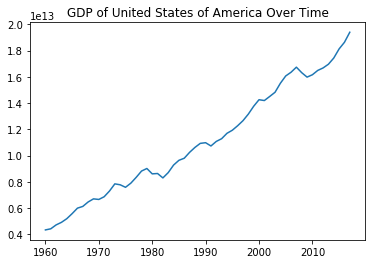

In [27]:
usgdp.applyFunction(['Basic ID','adjustedGDP_P2131','GDP_point_in_time_P2131_P585'],createGDPOVerTimeVisualization)

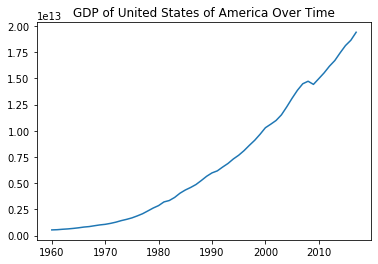

In [28]:
usgdp.applyFunction(['Basic ID','GDP_P2131','GDP_point_in_time_P2131_P585'],createGDPOVerTimeVisualization)

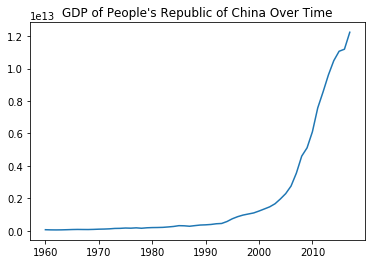

In [29]:
chinagdp = createRelation('Q148')
chinagdp.extend('P2131', False, 'GDP', colVerbose=True, rowVerbose=True)
chinagdp.query()
chinagdp.applyFunction(['Basic ID','GDP_P2131','GDP_point_in_time_P2131_P585'],createGDPOVerTimeVisualization)